<a href="https://www.kaggle.com/code/dascient/uacp-defining-powellscore-veracity-variables?scriptVersionId=145448474" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 2.0 UACP - Defining PowellScore & Veracity Variables
## [1.0 UAP Analytic Centralization Program](https://www.kaggle.com/code/dascient/uacp-uap-analytic-centralization-program)
<br>

## [NLP - Sentiment Intensity Analyzer](https://github.com/cjhutto/vaderSentiment) Against Reporting Comments
<br>

### In collaboration with The Scientific Coalition for UAP Studies [(SCU)](ExploreSCU.org).
Here we isolate only pertinent variables from the original dataset. We've also decided to leave open most of the code cells below; enabling transparency on foundation of all variables. 

In [12]:
%%time
# for the sake of expeditious analysis
!pip install xlrd
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from geopandas import GeoDataFrame
import matplotlib.colors as colors
import seaborn as sns
import random as r

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        #print('Files loaded.')
        
pd.set_option('display.max_colwidth', None)

# loading first nuforc dataframe
og_df1 = pd.read_csv('/kaggle/input/ufo-sightings/ufos.csv',header=0)
df = og_df1.dropna().copy()
og_df2 = pd.read_csv('/kaggle/input/d/NUFORC/ufo-sightings/scrubbed.csv',header=0)
df2 = og_df2.dropna().copy()

#############################################

lex = pd.read_excel('/kaggle/input/scu-nlp-uap-lexicon/UFO lexicon rev2.xls',sheet_name='Sheet1',header=7)
lex = lex.dropna(how='all').drop(columns='Unnamed: 0').copy()

#############################################
# sanitize
# drop some columns, for now
df = df.drop(columns=['datetime','duration (hours/min)'])

# date posted deemed to be easily conveible to timestamp values, so i'm gonna work with that for now.
df['date posted'] = df['date posted'].astype('datetime64[ns]')


# length of comments
df['comment_length'] = [len(str(v[0:500])) for i,v in df.comments.items()]


# convert seconds to minutes
df["duration (minutes)"] = [int(v)/60 for i,v in df["duration (seconds)"].items()]


# creating Geo Point column for sopecial use below
df['Geo Point'] = df.apply(lambda x:'%s, %s' % (x['latitude'],x['longitude']),axis=1)


# let's create subsets of our 80,000 here: 
# we can implement conditionals, remove/analyze outliers, 
# & will enable for back referencing when starting to run 
# robust AI-ML modeling that would otherwise take much longer to run.

# let's create subsets from the main dataframe/reporting-data w/ respect to duration of observations
df_under100 = df[df["duration (minutes)"]<100]
df_under60 = df[df["duration (minutes)"]<60]

# random binary column for future AI-ML modeling.
a=['balloon','spacejunk','sensor_malfunction','undentified','anomalous']     
df['verified'] = pd.Series(r.choices(a,k=len(df),weights=(50, 40, 30, 20, 10)),index=df.index)

# shape-focused
circles = df[df['shape'] == 'circle']
spheres = df[df['shape'] == 'sphere']
lights = df[df['shape'] == 'light']
teardrops = df[df['shape'] == 'teardrop']

# year-month
df['year_month'] = df['date posted'].dt.to_period('M')

clear_output()
# show
print("\nOriginal dataset.")
print(f"\nReports: {len(df)} non-null dataframe.")
print("\nMatrix:",df.shape[0],"rows,",df.shape[1],"columns")
df = df.sort_values('date posted',ascending=True).reset_index(drop=True)
df.tail(11).reset_index(drop=True).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'}).set_properties(**{'text-align': 'left'})


Original dataset.

Reports: 66516 non-null dataframe.

Matrix: 66516 rows, 14 columns
CPU times: user 2.23 s, sys: 258 ms, total: 2.49 s
Wall time: 12.3 s


# Lexicon

In [13]:
#lex[lex['RATING']!=0]
#lex[lex['Previous Rating']!=0]
# non-zero rating words
lex_nonzero = lex[lex['RATING']!=0]

#lex[lex['Previous Rating']>=3]
# rating words gerater than or equal to 3
#lex_nonzero = lex[lex['RATING']>=3]
lex_nonzero

WORD  RATING COMMENTS     WORD.1  Previous Rating
1           911     3.0      NaN        911              1.0
6         above     2.0      NaN      above              2.0
10           AF     3.0      NaN         AF              1.0
13        again    -2.0      NaN      again             -1.0
18    air force     3.0      NaN  air force              1.0
...         ...     ...      ...        ...              ...
1121  witnesses     3.0      NaN  witnesses              3.0
1129      yards     2.0      NaN      yards              2.0
1137       zoom    -2.0      NaN       zoom             -2.0
1138     zoomed    -2.0      NaN     zoomed             -2.0
1140        NaN     NaN                 NaN              NaN

[349 rows x 5 columns]

## Hash through each comment to find only those that include non-zero lexicon words. 

In [6]:
%%time
import time
from nltk.tokenize import word_tokenize

df_sample = df.sample(1000)

# hash through each comment to find only those that include non-zero lexicon words
lexicon_favored = df_sample.copy()
lexicon_favored['rating'] = pd.Series()
lexicon_favored['lexicon_word'] = pd.Series()
lexicon_favored['word_count'] = pd.Series()

for i,word in lex_nonzero.WORD.items():
    for i2,piece in df_sample.comments.items():     
        if word in word_tokenize(piece.lower()):
            #print('index',i2,'\nword',word, '\npiece',piece.lower(), '\nrating', lex_nonzero.RATING[i],'\n')

            # add rating from lexicon
            lexicon_favored['rating'][i2] = lex_nonzero.RATING[i]

            # add up every word usage in comments
            lexicon_favored['lexicon_word'][i2] = lex_nonzero.WORD[i]
            
            # word count
            lexicon_favored['word_count'][i2] = len(word_tokenize(piece.lower()))
        else:
            # word count
            lexicon_favored['word_count'][i2] = len(word_tokenize(piece.lower()))
            
lexicon_favored = lexicon_favored
#clear_output()

CPU times: user 2min 34s, sys: 21.4 ms, total: 2min 34s
Wall time: 2min 34s


### Lexicon-Focused Dataset
<br>

#### Snippet

In [7]:
lexicon_favored.head()

city state country    shape  duration (seconds)  \
18307      magnolia    ms      us    cigar               300.0   
64351         price    ut      us   sphere               300.0   
34695  blue springs    mo      us  chevron               900.0   
16376        helena    mt      us   sphere                 5.0   
20498         emory    tx      us      egg                 5.0   

                                                                                                                           comments  \
18307  Oval shaped object with flashing lights had no sound &amp; it only was there few minutes &amp; left as a flash thru the sky.   
64351                                                                                         Mars like object traverses night sky.   
34695                                                                                 2 UFOs Seen After A Fierce Thunder/Hail Storm   
16376                        On my way to work at 0410&#44 I witnessed a pulsating&#44 green orb descend diagonally in front of me.   
20498                                                I saw a reddish orange egg shaped object fly north to south at a low altitude.   

      date posted   latitude   longitude  comment_length  duration (minutes)  \
18307  2004-06-18  31.143056  -90.458611             124            5.000000   
64351  2014-01-10  39.599444 -110.810000              37            5.000000   
34695  2008-06-12  39.016944  -94.281389              45           15.000000   
16376  2004-01-17  46.592778 -112.035278             102            0.083333   
20498  2005-01-11  32.874444  -95.765278              78            0.083333   

                      Geo Point     verified year_month  rating lexicon_word  \
18307   31.1430556, -90.4586111      balloon    2004-06     2.0       object   
64351       39.5994444, -110.81      balloon    2014-01     2.0       object   
34695   39.0169444, -94.2813889      balloon    2008-06    -3.0         ufos   
16376  46.5927778, -112.0352778  undentified    2004-01     2.0    witnessed   
20498   32.8744444, -95.7652778      balloon    2005-01     3.0        south   

       word_count  
18307        29.0  
64351         7.0  
34695         8.0  
16376        26.0  
20498        17.0

In [8]:
any(lexicon_favored.index.duplicated())

False

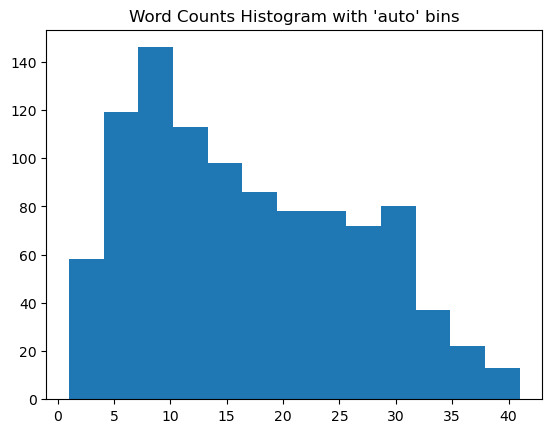

In [9]:
import matplotlib.pyplot as plt
_ = plt.hist(lexicon_favored.word_count, bins='auto')  # arguments are passed to np.histogram
plt.title("Word Counts Histogram with 'auto' bins")
plt.show()

In [10]:
# stopwords
import nltk
from nltk.corpus import stopwords
 
#nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

lexicon_favored['just_words'] = pd.Series()
filtered_sentence = []

for i,piece in lexicon_favored.comments.items():     
    for word in word_tokenize(piece.lower()):
        if word not in stop_words:
            filtered_sentence.append({i, word})

### Ranked by Lexicon Rating.

In [11]:
lexicon_favored = lexicon_favored.sort_values('rating',ascending=False).reset_index(drop=True)
lexicon_favored.head(25).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

# "Be careful not to choke on your aspirations." - Darth Vader
### Application of [VADER](https://github.com/cjhutto/vaderSentiment) (Valence Aware Dictionary and sEntiment Reasoner)
A lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [19]:
# https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
# https://github.com/cjhutto/vaderSentiment
#
# Natural Language Toolkit: vader - TAMPERED w/ SCU Lexicon
#
# Copyright (C) 2001-2023 NLTK Project
# Author: C.J. Hutto <Clayton.Hutto@gtri.gatech.edu>
#         Ewan Klein <ewan@inf.ed.ac.uk> (modifications)
#         Pierpaolo Pantone <24alsecondo@gmail.com> (modifications)
#         George Berry <geb97@cornell.edu> (modifications)
#         Malavika Suresh <malavika.suresh0794@gmail.com> (modifications)
# URL: <https://www.nltk.org/>
"""
If you use the VADER sentiment analysis tools, please cite:

Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for
Sentiment Analysis of Social Media Text. Eighth International Conference on
Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.
"""
import math
import re
import string
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from IPython.display import clear_output
import nltk.data
clear_output()

class VaderConstants:
    """
    A class to keep the Vader lists and constants.
    """

    ##Constants##
    # (empirically derived mean sentiment intensity rating increase for booster words)
    B_INCR = 0.293
    B_DECR = -0.293

    # (empirically derived mean sentiment intensity rating increase for using
    # ALLCAPs to emphasize a word)
    C_INCR = 0.733

    N_SCALAR = -0.74

    NEGATE = {'UFO',
             'again',
             'alien',
             'another',
             'attack',
             'beam',
             'beautiful',
             'bed',
             'bedroom',
             'being',
             'believe',
             'capture',
             'caught',
             'chase',
             'chemtrail',
             'cloud',
             'clouds',
             'coming',
             'confuse',
             'contact',
             'daily',
             "didn't",
             'discover',
             'dream',
             'earth',
             'every',
             'excited',
             'experience',
             'figure',
             'fireball',
             'firework',
             'fireworks',
             'frequent',
             'happy',
             'help',
             'hope',
             'less',
             'me',
             'mufon',
             'needle',
             'nightly',
             'often',
             'orange',
             'pain',
             'paranormal',
             'please',
             'presence',
             'psychic',
             'review',
             'room',
             'scared',
             'seen',
             'shock',
             'shocked',
             'skin',
             'sleep',
             'star-like',
             'starlike',
             'starship',
             'storm',
             'surgery',
             'taken',
             'their',
             'thigh',
             'tragedy',
             'trance',
             'ufo',
             "ufo's",
             'ufos',
             'visit',
             'visitation',
             'want',
             'zoom',
             'zoomed'
             }


    # booster/dampener 'intensifiers' or 'degree adverbs'
    # https://en.wiktionary.org/wiki/Category:English_degree_adverbs

    BOOSTER_DICT = {
        'northeastern'  : B_INCR,
        'law'  : B_INCR,
        'duty'  : B_INCR,
        'appearing'  : B_INCR,
        'background'  : B_INCR,
        'clockwise'  : B_INCR,
        'momentarily'  : B_INCR,
        'degrees'  : B_INCR,
        'appearance'  : B_INCR,
        'approx'  : B_INCR,
        'approximate'  : B_INCR,
        'within'  : B_INCR,
        'NORAD'  : B_INCR,
        'plasma'  : B_INCR,
        'astronomical'  : B_INCR,
        'Lockheed'  : B_INCR,
        'retire'  : B_INCR,
        'locomotion'  : B_INCR,
        'feather'  : B_INCR,
        'seemed'  : B_INCR,
        'witnesses'  : B_INCR,
        'aviation'  : B_INCR,
        'nuclear'  : B_INCR,
        'air force'  : B_INCR,
        'north'  : B_INCR,
        'seem'  : B_INCR,
        'fort'  : B_INCR,
        'register'  : B_INCR,
        'translucent'  : B_INCR,
        'hexagon'  : B_INCR,
        'normal'  : B_INCR,
        'target'  : B_INCR,
        'morning'  : B_INCR,
        'rotar'  : B_INCR,
        'southwest'  : B_INCR,
        'AF'  : B_INCR,
        'south'  : B_INCR,
        'approach'  : B_INCR,
        'opaque'  : B_INCR,
        'hexagonal'  : B_INCR,
        'guard'  : B_INCR,
        'briefly'  : B_INCR,
        'rectangular'  : B_INCR,
        'upward'  : B_INCR,
        'officer'  : B_INCR,
        'telescope'  : B_INCR,
        'propulsion'  : B_INCR,
        'perimeter'  : B_INCR,
        'traverse'  : B_INCR,
        'army'  : B_INCR,
        'eastern'  : B_INCR,
        'elongate'  : B_INCR,
        'customer'  : B_INCR,
        'binoculars'  : B_INCR,
        'pulled'  : B_INCR,
        'emanate'  : B_INCR,
        'scope'  : B_INCR,
        'southern'  : B_INCR,
        'assume'  : B_INCR,
        'capability'  : B_INCR,
        'radar'  : B_INCR,
        'structure'  : B_INCR,
        'tree-line'  : B_INCR,
        'appear'  : B_INCR,
        'western'  : B_INCR,
        'defense'  : B_INCR,
        'irregular'  : B_INCR,
        'call'  : B_INCR,
        'analyze'  : B_INCR,
        'coast  '  : B_INCR,
        'vertex'  : B_INCR,
        'altitude'  : B_INCR,
        'grid'  : B_INCR,
        'blend'  : B_INCR,
        'public'  : B_INCR,
        'northern'  : B_INCR,
        'simultaneous'  : B_INCR,
        'perspective'  : B_INCR,
        'capable'  : B_INCR,
        'navy'  : B_INCR,
        'degree'  : B_INCR,
        'family'  : B_INCR,
        'east'  : B_INCR,
        'enforcement'  : B_INCR,
        'position'  : B_INCR,
        'F14'  : B_INCR,
        'astronomy'  : B_INCR,
        'police'  : B_INCR,
        'base'  : B_INCR,
        'security'  : B_INCR,
        'velocity'  : B_INCR,
        'similar'  : B_INCR,
        'civilian'  : B_INCR,
        'pilot'  : B_INCR,
        'F15'  : B_INCR,
        'southeastern'  : B_INCR,
        'Boeing'  : B_INCR,
        'counterclockwise'  : B_INCR,
        'estimate'  : B_INCR,
        'sentry'  : B_INCR,
        'sheriff'  : B_INCR,
        'assign'  : B_INCR,
        'B2'  : B_INCR,
        'cloak'  : B_INCR,
        'west'  : B_INCR,
        'northwest'  : B_INCR,
        'military'  : B_INCR,
        'marine'  : B_INCR,
        'engine'  : B_INCR,
        'reception'  : B_INCR,
        'treeline'  : B_INCR,
        '911'  : B_INCR,
        'radio'  : B_INCR,
        'southeast'  : B_INCR,
        'height'  : B_INCR,
        'rotating'  : B_INCR,
        'rotate'  : B_INCR,
        'octagonal'  : B_INCR,
        'day'  : B_INCR,
        'physics'  : B_INCR,
        'border'  : B_INCR,
        'northwestern'  : B_INCR,
        'cluster'  : B_INCR,
        'appeared'  : B_INCR,
        'solid'  : B_INCR,
        'rotary'  : B_INCR,
        'horizontal'  : B_INCR,
        'approximately'  : B_INCR,
        'equidistant'  : B_INCR,
        'independent'  : B_INCR,
        'naval'  : B_INCR,
        'policeman'  : B_INCR,
        'resemble'  : B_INCR,
        'northeast'  : B_INCR,
        'commercial'  : B_INCR,
        'southwestern'  : B_INCR,
        'octagon'  : B_INCR,
        'motion'  : B_INCR,
        'deputy'  : B_INCR,
        'daytime'  : B_INCR,
        'flight'  : B_INCR,
        'biologist'  : B_INCR,
        'silo'  : B_INCR,
        'patrol'  : B_INCR,
        'chemist'  : B_INCR,
        'perfect'  : B_INCR,
        'astronomer'  : B_INCR,
        'azimuth'  : B_INCR,
        'radioed'  : B_INCR,
        'elevation'  : B_INCR,
        'coast guard'  : B_INCR,
        'engineer'  : B_INCR,
        'reports'  : B_DECR,
        'towards'  : B_DECR,
        'directions'  : B_DECR,
        'attention'  : B_DECR,
        'directly'  : B_DECR,
        'friends'  : B_DECR,
        'triangle'  : B_DECR,
        'ft'  : B_DECR,
        'pictures'  : B_DECR,
        'event'  : B_DECR,
        'father'  : B_DECR,
        'observe '  : B_DECR,
        'observing'  : B_DECR,
        'extremely'  : B_DECR,
        'standing'  : B_DECR,
        'visible'  : B_DECR,
        'spherical'  : B_DECR,
        'angle'  : B_DECR,
        'hover'  : B_DECR,
        'triangular'  : B_DECR,
        'location'  : B_DECR,
        'diameter'  : B_DECR,
        'direction'  : B_DECR,
        'close'  : B_DECR,
        'speed'  : B_DECR,
        'hovered'  : B_DECR,
        'between'  : B_DECR,
        'object'  : B_DECR,
        'glow'  : B_DECR,
        'sister'  : B_DECR,
        'clearly'  : B_DECR,
        'never'  : B_DECR,
        'trees'  : B_DECR,
        'son'  : B_DECR,
        'near'  : B_DECR,
        'facing'  : B_DECR,
        'movement'  : B_DECR,
        'realized'  : B_DECR,
        'photos'  : B_DECR,
        'behind'  : B_DECR,
        'witnessed'  : B_DECR,
        'cloudy'  : B_DECR,
        'immediate'  : B_DECR,
        'notice'  : B_DECR,
        'camera'  : B_DECR,
        'large'  : B_DECR,
        'brother'  : B_DECR,
        'underneath'  : B_DECR,
        'asked'  : B_DECR,
        'closer'  : B_DECR,
        'called'  : B_DECR,
        'photo'  : B_DECR,
        'yards'  : B_DECR,
        'highway'  : B_DECR,
        'down'  : B_DECR,
        'objects'  : B_DECR,
        'video'  : B_DECR,
        'assumed'  : B_DECR,
        'horizon'  : B_DECR,
        'tree'  : B_DECR,
        'station'  : B_DECR,
        'mile'  : B_DECR,
        'shape'  : B_DECR,
        'together'  : B_DECR,
        'ground'  : B_DECR,
        'mountain'  : B_DECR,
        'mother'  : B_DECR,
        'observed'  : B_DECR,
        'curious'  : B_DECR,
        'fairly'  : B_DECR,
        'feet'  : B_DECR,
        'miles'  : B_DECR,
        'ocean'  : B_DECR,
        'below'  : B_DECR,
        'brightness'  : B_DECR,
        'bottom'  : B_DECR,
        'hill'  : B_DECR,
        'pattern'  : B_DECR,
        'remember'  : B_DECR,
        'daughter'  : B_DECR,
        'hovering'  : B_DECR,
        'joke'  : B_DECR,
        'stationary'  : B_DECR,
        'metallic'  : B_DECR,
        'probably'  : B_DECR,
        'top'  : B_DECR,
        'might'  : B_DECR,
        'approaching'  : B_DECR,
        'slightly'  : B_DECR,
        'smaller'  : B_DECR,
        'toward'  : B_DECR,
        'above'  : B_DECR,
        'different'  : B_DECR,
        'husband'  : B_DECR,
        'glowing'  : B_DECR,
        'mom'  : B_DECR,
        'water'  : B_DECR,
        'wasnt'  : B_DECR,
        'path'  : B_DECR,
        'friend'  : B_DECR,
        'dad'  : B_DECR,
        'observation'  : B_DECR,
        'center'  : B_DECR,
        'began'  : B_DECR,
        'course'  : B_DECR,
        'smoke'  : B_DECR,
        'cigar'  : B_DECR,
        'located'  : B_DECR,
        'overhead'  : B_DECR,
        'minutes'  : B_DECR,
        'dog'  : B_DECR,
        'witness'  : B_DECR,
        'cold'  : B_DECR,
        'report'  : B_DECR,
        'wife'  : B_DECR,
        'appears'  : B_DECR,
        'bright'  : B_DECR,
        'moon'  : B_DECR,
        'moving'  : B_DECR,
        'craft'  : B_DECR,
        'brighter'  : B_DECR,
    }

    # check for special case idioms using a sentiment-laden keyword known to SAGE
    SPECIAL_CASE_IDIOMS = {
        "the shit": 3,
        "the bomb": 3,
        "bad ass": 1.5,
        "yeah right": -2,
        "cut the mustard": 2,
        "kiss of death": -1.5,
        "hand to mouth": -2,
    }

    # for removing punctuation
    REGEX_REMOVE_PUNCTUATION = re.compile(f"[{re.escape(string.punctuation)}]")

    PUNC_LIST = [
        ".",
        "!",
        "?",
        "&",
        "&#44",
        "&#39",
        ",",
        ";",
        ":",
        "-",
        "'",
        '"',
        "!!",
        "!!!",
        "??",
        "???",
        "?!?",
        "!?!",
        "?!?!",
        "!?!?",
    ]

    def __init__(self):
        pass

    def pairwise(iterable):
        """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
        a, b = tee(iterable)
        next(b, None)
        return zip(a, b)
    
    def negated(self, input_words, include_nt=True):
        """
        Determine if input contains negation words
        """
        neg_words = self.NEGATE
        if any(word.lower() in neg_words for word in input_words):
            return True
        if include_nt:
            if any("n't" in word.lower() for word in input_words):
                return True
        #for first, second in pairwise(input_words):
        #    if second.lower() == "least" and first.lower() != "at":
        #        return True
        return False


    def normalize(self, score, alpha=15):
        """
        Normalize the score to be between -1 and 1 using an alpha that
        approximates the max expected value
        """
        norm_score = score / math.sqrt((score * score) + alpha)
        return norm_score


    def scalar_inc_dec(self, word, valence, is_cap_diff):
        """
        Check if the preceding words increase, decrease, or negate/nullify the
        valence
        """
        scalar = 0.0
        word_lower = word.lower()
        if word_lower in self.BOOSTER_DICT:
            scalar = self.BOOSTER_DICT[word_lower]
            if valence < 0:
                scalar *= -1
            # check if booster/dampener word is in ALLCAPS (while others aren't)
            if word.isupper() and is_cap_diff:
                if valence > 0:
                    scalar += self.C_INCR
                else:
                    scalar -= self.C_INCR
        return scalar



class SentiText:
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text, punc_list, regex_remove_punctuation):
        if not isinstance(text, str):
            text = str(text.encode("utf-8"))
        self.text = text
        self.PUNC_LIST = punc_list
        self.REGEX_REMOVE_PUNCTUATION = regex_remove_punctuation
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = self.allcap_differential(self.words_and_emoticons)


    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = self.REGEX_REMOVE_PUNCTUATION.sub("", self.text)
        # removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()
        # remove singletons
        words_only = {w for w in words_only if len(w) > 1}
        # the product gives ('cat', ',') and (',', 'cat')
        punc_before = {"".join(p): p[1] for p in product(self.PUNC_LIST, words_only)}
        punc_after = {"".join(p): p[0] for p in product(words_only, self.PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes

    def allcap_differential(self, words):
        """
        Check whether just some words in the input are ALL CAPS

        :param list words: The words to inspect
        :returns: `True` if some but not all items in `words` are ALL CAPS
        """
        is_different = False
        allcap_words = 0
        for word in words:
            if word.isupper():
                allcap_words += 1
        cap_differential = len(words) - allcap_words
        if 0 < cap_differential < len(words):
            is_different = True
        return is_different



class SentimentIntensityAnalyzer:
    """
    Give a sentiment intensity score to sentences.
    """

    def __init__(
        self,
        lexicon_file="sentiment/vader_lexicon.zip/vader_lexicon/vader_lexicon.txt",
    ):
        self.lexicon_file = nltk.data.load(lexicon_file)
        self.lexicon = self.make_lex_dict()
        self.constants = VaderConstants()


    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_file.split("\n"):
            (word, measure) = line.strip().split("\t")[0:2]
            lex_dict[word] = float(measure)
        return lex_dict


    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.

        :note: Hashtags are not taken into consideration (e.g. #BAD is neutral). If you
            are interested in processing the text in the hashtags too, then we recommend
            preprocessing your data to remove the #, after which the hashtag text may be
            matched as if it was a normal word in the sentence.
        """
        # text, words_and_emoticons, is_cap_diff = self.preprocess(text)
        sentitext = SentiText(
            text, self.constants.PUNC_LIST, self.constants.REGEX_REMOVE_PUNCTUATION
        )
        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            if (
                i < len(words_and_emoticons) - 1
                and item.lower() == "kind"
                and words_and_emoticons[i + 1].lower() == "of"
            ) or item.lower() in self.constants.BOOSTER_DICT:
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)

        return self.score_valence(sentiments, text)


    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            # get the sentiment valence
            valence = self.lexicon[item_lowercase]

            # check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += self.constants.C_INCR
                else:
                    valence -= self.constants.C_INCR

            for start_i in range(0, 3):
                if (
                    i > start_i
                    and words_and_emoticons[i - (start_i + 1)].lower()
                    not in self.lexicon
                ):
                    # dampen the scalar modifier of preceding words and emoticons
                    # (excluding the ones that immediately preceed the item) based
                    # on their distance from the current item.
                    s = self.constants.scalar_inc_dec(
                        words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff
                    )
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._never_check(
                        valence, words_and_emoticons, start_i, i
                    )
                    if start_i == 2:
                        valence = self._idioms_check(valence, words_and_emoticons, i)

                        # future work: consider other sentiment-laden idioms
                        # other_idioms =
                        # {"back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                        #  "upper hand": 1, "break a leg": 2,
                        #  "cooking with gas": 2, "in the black": 2, "in the red": -2,
                        #  "on the ball": 2,"under the weather": -2}

            valence = self._least_check(valence, words_and_emoticons, i)

        sentiments.append(valence)
        return sentiments


    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if (
            i > 1
            and words_and_emoticons[i - 1].lower() not in self.lexicon
            and words_and_emoticons[i - 1].lower() == "least"
        ):
            if (
                words_and_emoticons[i - 2].lower() != "at"
                and words_and_emoticons[i - 2].lower() != "very"
            ):
                valence = valence * self.constants.N_SCALAR
        elif (
            i > 0
            and words_and_emoticons[i - 1].lower() not in self.lexicon
            and words_and_emoticons[i - 1].lower() == "least"
        ):
            valence = valence * self.constants.N_SCALAR
        return valence

    def _but_check(self, words_and_emoticons, sentiments):
        words_and_emoticons = [w_e.lower() for w_e in words_and_emoticons]
        but = {"but"} & set(words_and_emoticons)
        if but:
            bi = words_and_emoticons.index(next(iter(but)))
            for sidx, sentiment in enumerate(sentiments):
                if sidx < bi:
                    sentiments[sidx] = sentiment * 0.5
                elif sidx > bi:
                    sentiments[sidx] = sentiment * 1.5
        return sentiments

    def _idioms_check(self, valence, words_and_emoticons, i):
        onezero = f"{words_and_emoticons[i - 1]} {words_and_emoticons[i]}"

        twoonezero = "{} {} {}".format(
            words_and_emoticons[i - 2],
            words_and_emoticons[i - 1],
            words_and_emoticons[i],
        )

        twoone = f"{words_and_emoticons[i - 2]} {words_and_emoticons[i - 1]}"

        threetwoone = "{} {} {}".format(
            words_and_emoticons[i - 3],
            words_and_emoticons[i - 2],
            words_and_emoticons[i - 1],
        )

        threetwo = "{} {}".format(
            words_and_emoticons[i - 3], words_and_emoticons[i - 2]
        )

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons) - 1 > i:
            zeroone = f"{words_and_emoticons[i]} {words_and_emoticons[i + 1]}"
            if zeroone in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[zeroone]
        if len(words_and_emoticons) - 1 > i + 1:
            zeroonetwo = "{} {} {}".format(
                words_and_emoticons[i],
                words_and_emoticons[i + 1],
                words_and_emoticons[i + 2],
            )
            if zeroonetwo in self.constants.SPECIAL_CASE_IDIOMS:
                valence = self.constants.SPECIAL_CASE_IDIOMS[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        if (
            threetwo in self.constants.BOOSTER_DICT
            or twoone in self.constants.BOOSTER_DICT
        ):
            valence = valence + self.constants.B_DECR
        return valence

    def _never_check(self, valence, words_and_emoticons, start_i, i):
        if start_i == 0:
            if self.constants.negated([words_and_emoticons[i - 1]]):
                valence = valence * self.constants.N_SCALAR
        if start_i == 1:
            if words_and_emoticons[i - 2] == "never" and (
                words_and_emoticons[i - 1] == "so"
                or words_and_emoticons[i - 1] == "this"
            ):
                valence = valence * 1.5
            elif self.constants.negated([words_and_emoticons[i - (start_i + 1)]]):
                valence = valence * self.constants.N_SCALAR
        if start_i == 2:
            if (
                words_and_emoticons[i - 3] == "never"
                and (
                    words_and_emoticons[i - 2] == "so"
                    or words_and_emoticons[i - 2] == "this"
                )
                or (
                    words_and_emoticons[i - 1] == "so"
                    or words_and_emoticons[i - 1] == "this"
                )
            ):
                valence = valence * 1.25
            elif self.constants.negated([words_and_emoticons[i - (start_i + 1)]]):
                valence = valence * self.constants.N_SCALAR
        return valence

    def _punctuation_emphasis(self, sum_s, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier
        return punct_emph_amplifier

    def _amplify_ep(self, text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count * 0.292
        return ep_amplifier

    def _amplify_qm(self, text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    def _sift_sentiment_scores(self, sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (
                    float(sentiment_score) + 1
                )  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (
                    float(sentiment_score) - 1
                )  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(sum_s, text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = self.constants.normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = {
            "neg": round(neg, 3),
            "neu": round(neu, 3),
            "pos": round(pos, 3),
            "compound": round(compound, 4),
        }

        return sentiment_dict


# function to print sentiments
# of the sentence.
def sentiment_scores(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # create a list
    results = []
    results.append({"% Positive":sentiment_dict['pos'],
                    "% Negative":sentiment_dict['neg'],
                    "% Neutral":sentiment_dict['neu'],
                    "% Compound":sentiment_dict['compound']
                   })
    results = pd.DataFrame(results)
    return results

# Apply to df['comments'] column.
def NLP_PowellScore(commentsColumns):
    
    # obtain each comment for 'comments' column
    eachComment = [eachComment for i,eachComment in commentsColumns.items()]
    eachComment = pd.Series(eachComment)
                               
    # vader.variables.PowellScore
    PowellPositive = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Positive"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNegative = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Negative"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellNeutral = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Neutral"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    PowellCompound = [v for v in list([sentiment_scores(sentimentAnalyzedComment)["% Compound"][0] for i,sentimentAnalyzedComment in eachComment.items()])]
    
    return PowellPositive,PowellNegative,PowellNeutral,PowellCompound

### Reports sorted by Veracity
We also added the "Rating" score from Lexicon.

In [13]:
# let's only take a small sample - this will definitely take a few minutes, grab yourself some water...
robert = lexicon_favored.copy()#.sample(30000)
robert.rating.value_counts()

 2.0    443
 3.0    174
-2.0     95
 1.0     66
-1.0     60
-3.0     21
 6.0      2
Name: rating, dtype: int64

In [14]:
%%time
# defining Powell Scores by sentiment outputs: Positive, Negative, Neutral, Compound, & Rating
robert["PowellPositive"] = NLP_PowellScore(robert['comments'])[0]
robert["PowellNegative"] = NLP_PowellScore(robert['comments'])[1]
robert["PowellNeutral"] = NLP_PowellScore(robert['comments'])[2]
robert["PowellCompound"] = NLP_PowellScore(robert['comments'])[3]

# PowellScore 
robert["PowellScore"] = robert["PowellCompound"]#(robert["PowellPositive"]-robert["PowellNegative"])/robert["PowellNeutral"]

# veracity
robert["veracity"] = robert["PowellScore"]/robert["comment_length"]#*robert["rating"] # FINALLY, THIS EQUATION ACCOUNTS FOR POWELL'S LEXICON RATINGS!

# veracity is still very much in progress. we are looking for ways forward to 
# better define them. although, it is important to note that "veracity" will 
# be variable that is subjective to the type of datasets.
columns = ['date posted','city','state','shape','comments',
           'comment_length','latitude','longitude','duration (minutes)',\
           'PowellCompound','veracity','rating','lexicon_word']

df1 = robert[columns].sort_values('veracity',ascending=False).reset_index(drop=True)
df1[df1['comment_length']>10].head(20)\
        .style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

CPU times: user 2min 4s, sys: 16.5 ms, total: 2min 4s
Wall time: 2min 4s


## Ovals seen in California

In [15]:
%%time
# ca_oval
ca_oval = df1[df1.state=='ca'].reset_index(drop=True)
ca_oval = ca_oval[ca_oval['shape']=='oval']

# only ovals
ca_oval_162 = ca_oval.sort_values(['latitude','longitude'])
robert_ca_oval_162 = ca_oval_162
robert_ca_oval_162["PowellPositive"] = NLP_PowellScore(robert_ca_oval_162['comments'])[0]
robert_ca_oval_162["PowellNegative"] = NLP_PowellScore(robert_ca_oval_162['comments'])[1]
robert_ca_oval_162["PowellNeutral"] = NLP_PowellScore(robert_ca_oval_162['comments'])[2]

# PowellScore 
robert_ca_oval_162["PowellScore"] = (robert_ca_oval_162["PowellPositive"]-robert_ca_oval_162["PowellNegative"])/robert_ca_oval_162["PowellNeutral"]

# veracity
robert_ca_oval_162["veracity"] = robert_ca_oval_162["PowellScore"]*robert_ca_oval_162["comment_length"]*robert_ca_oval_162["rating"]


df2 = robert_ca_oval_162[columns].sort_values(['veracity'],ascending=False).reset_index(drop=True)
df2.head(50).style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

CPU times: user 946 ms, sys: 2.89 ms, total: 949 ms
Wall time: 951 ms


## Powell Variables in 3D
This is a 3D-interactive chart that uses the date posted, veracity, & PowellScore variables. Colored by lexicon rating. Sized by comment_length.

By definition, these actually render 5-Dimensional charts, if one considers veracity & commenth lengths of reports as 'features of a situation'.

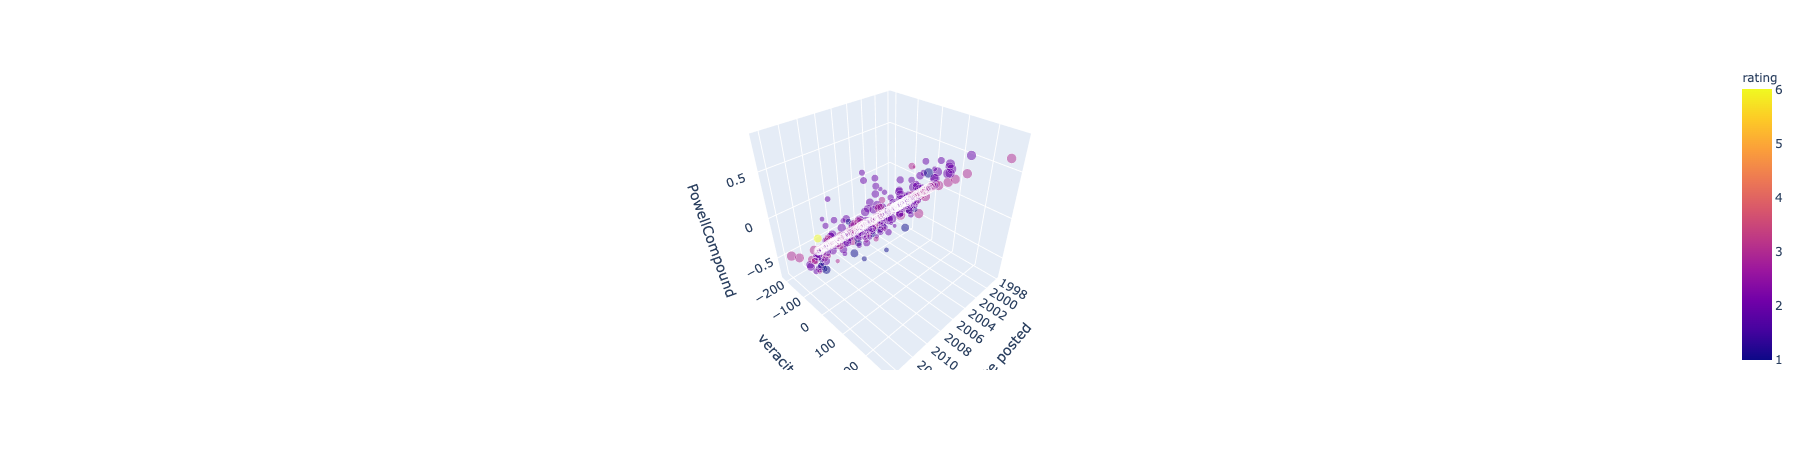

In [17]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

df_plot = df1[df1.rating>0]
# graph
fig = px.scatter_3d(df_plot, x='date posted', y='veracity', z='PowellCompound',
              color='rating',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments','rating','lexicon_word'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### This one shows Date Posted vs PowellScore & Lexicon Rating Variables of California Oval reports. Colored by Veracity.

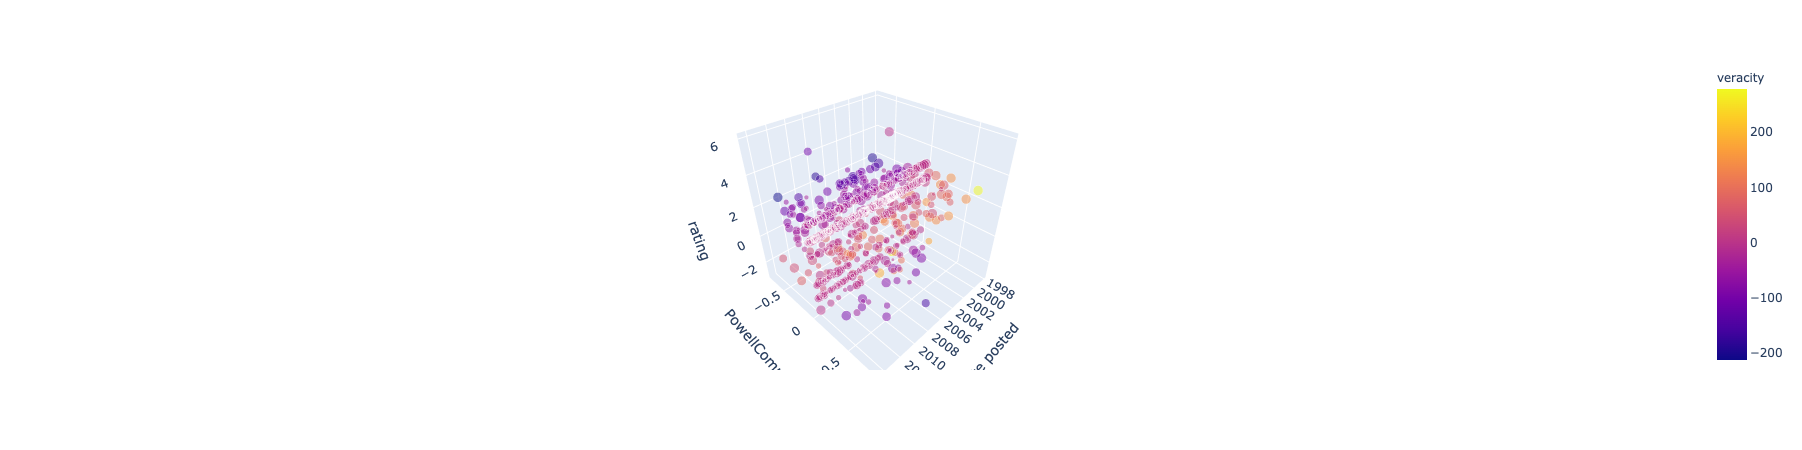

In [19]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(df1, x='date posted', y='PowellCompound', z='rating',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments','rating','lexicon_word'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

### Ovals seen in California - Date Posted vs PowellNeutral vs PowellScore

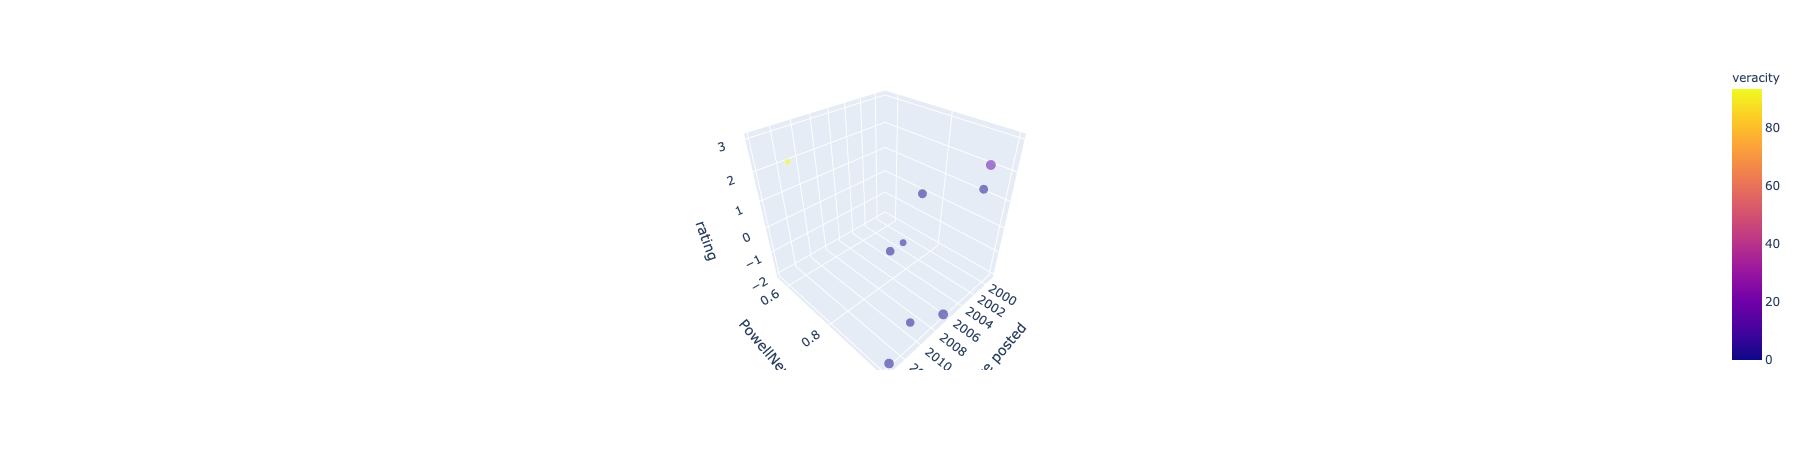

In [20]:
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# graph
fig = px.scatter_3d(robert_ca_oval_162, x='date posted', y='PowellNeutral', z='rating',
              color='veracity',
              size = 'comment_length',
              hover_name = 'city',
              hover_data=['city','state','comments','shape','veracity','rating'],              
              opacity=0.5,
              size_max=17
                   )
fig.show()

These variables are still very much in progress & there currently is no process for defining them. Despite the disparate, disconnected, & wide range of skeptic/non-skeptic relational databases — we have managed to connect with organizations that promote open source — public repositories & most are willing to coordinate with one another in developing a UAP Reporting & Events Hub. Wherein all pertinent reports, sightings, measurements, & signatures are to be populated by various factors from multiple disciplines & technologies. We will do our best to coordinate with prominent key members of the UAP community in order to contribute to building out a “standardized” reporting mechanism in an intelligible & non-duplicative fashion. We are looking for ways forward in getting access to real-time, current reports.

The goal would be to create something similar to an Order of Battle, so that reports at specific times & locations can be compared to past reports to augment credibility determination, as well as eventually be compared to known events that may explain them. Once those explanations are vetted, reports would be coded by likelihood of mundane vs anomalous, which would aid in the processing of similar events in the future.

In addition, we have already begun looking for trends over time, such as the time of day when reported events take place, & the type of object reported over the decades. The latter can be observed in the “Shapes by Share of Reports” chart, which provides indications of confirmation bias in observed behavior.

Finally, big data analysis (alongside robust AI|ML|DS modeling techniques) could also provide insight into the development of improved collection & reporting processes, which currently appear to be undefined, improving the quality of the data we receive. — K. Kolbe.

# Visual Insights

## Word Clouds
### All 500 samples.

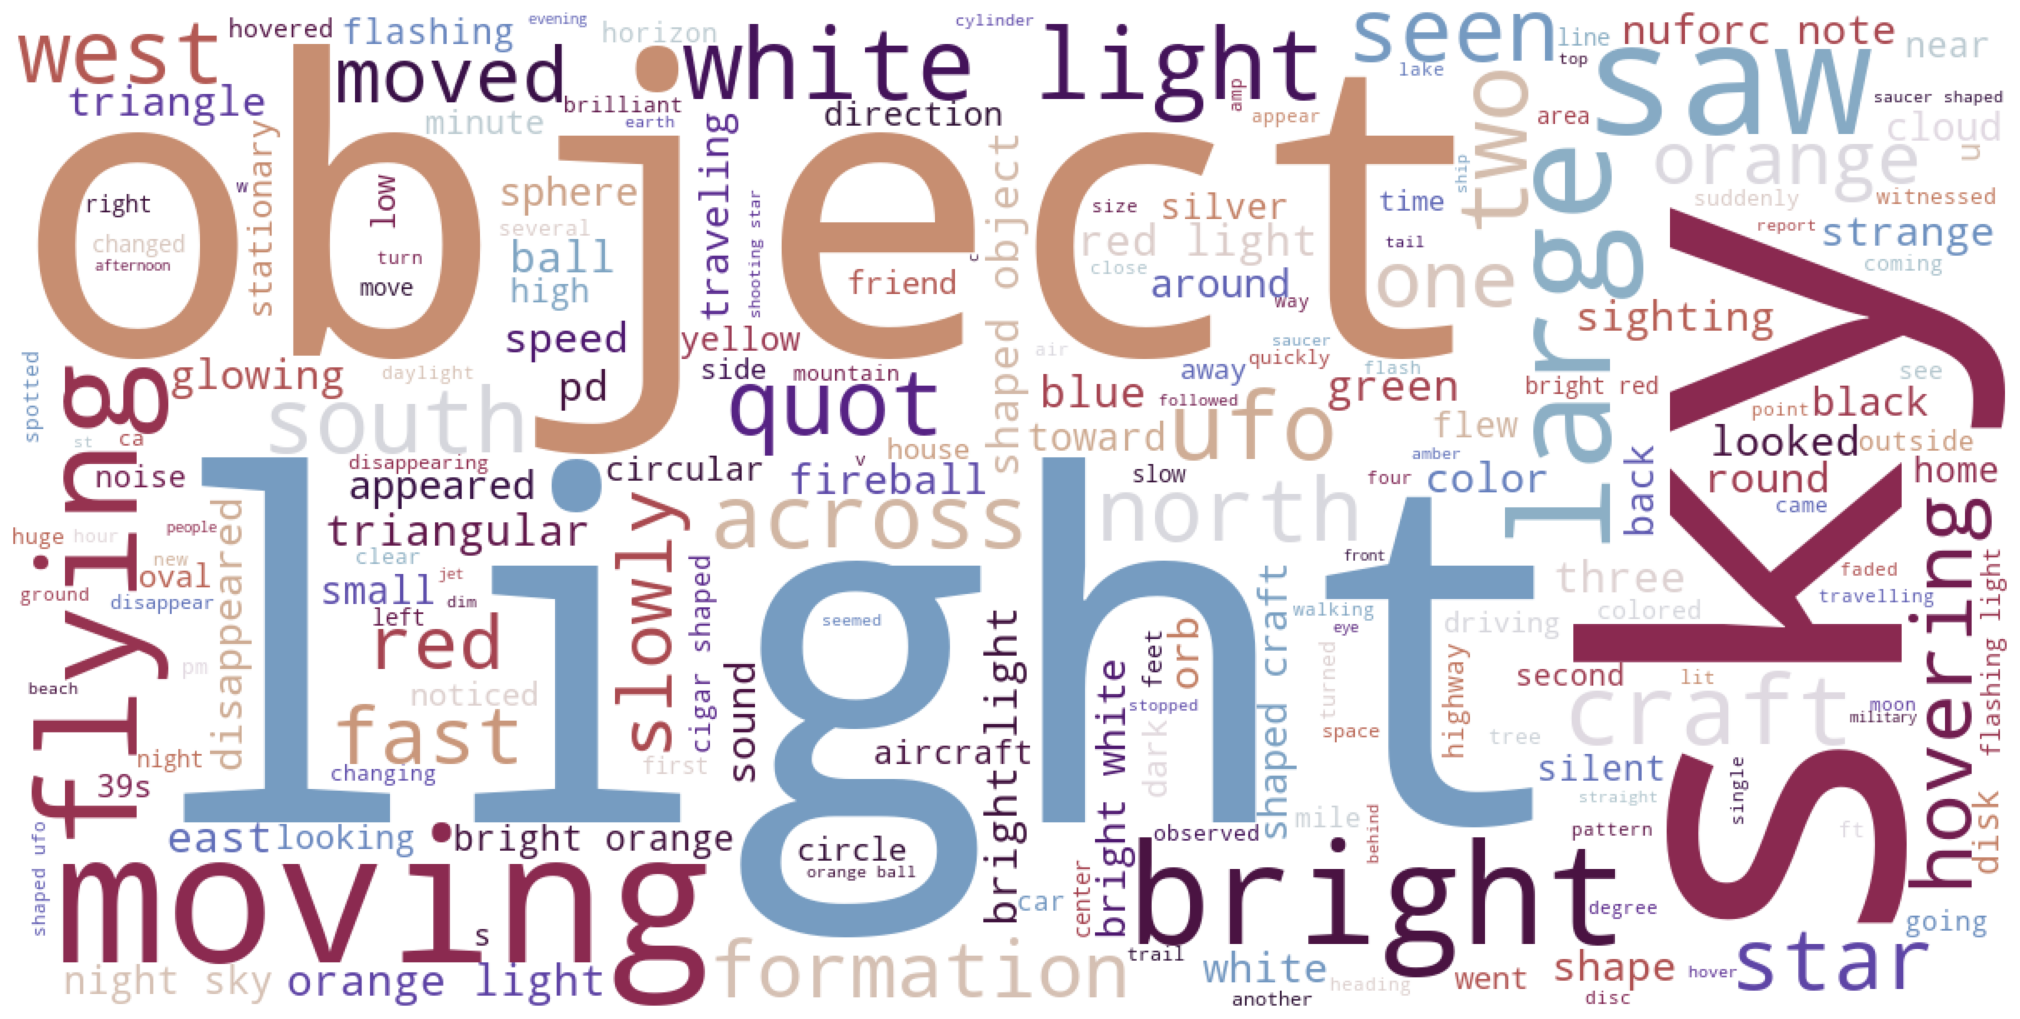

In [24]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# in the clouds
# 500 samples 
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df1.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 7,
                colormap='twilight').generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize=(25,10), facecolor='None')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### California Ovals 

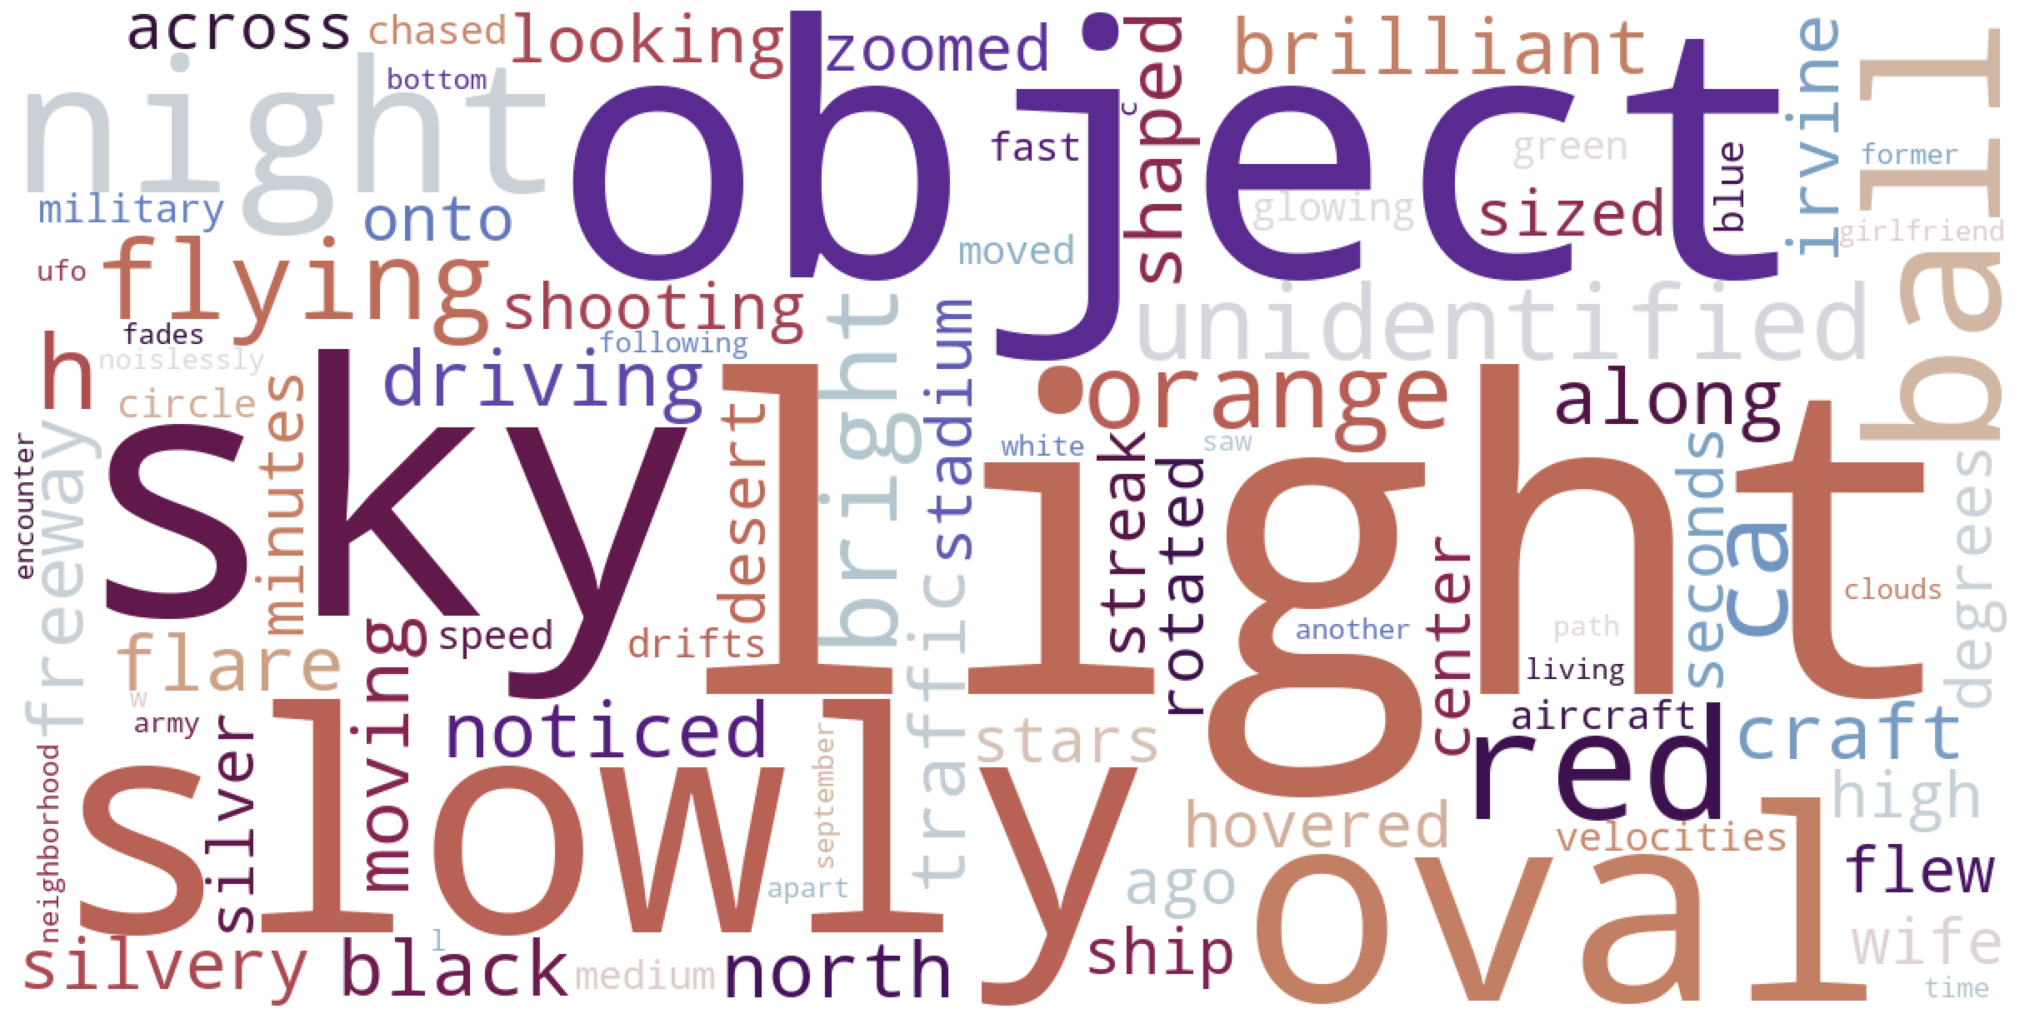

In [25]:
# in the clouds
# california ovals
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df2.comments:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 1200, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 7,
                colormap='twilight').generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize=(25,10), facecolor='None')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

### Top Veracity Comments

In [26]:
df1.reset_index(drop=True).set_index('veracity').head(20)[['comments','rating','lexicon_word','shape','city']]

comments  \
veracity                                                                                                                                                  
277.4202         IT FIRST SEEM LIKE A DYING STAR FLASHING ..IT WOULD DIM THEN BRIGHTEN THEN IT STARTED MOVING UP DOWN IN A CIRCLE IT WOULD GO FRONTWARD   
276.0966     first saw it as a white light with a brilliant orange tail&#44 tail disappeared white light continued across sky east and then seemed to b   
184.7160   I am just finding out about this place and I wish I would have known years ago I would have called but back then I didn&#8217;t have a smart   
178.4982                     I saw a luminous silver colored cigar shaped object travelling west to E.  It was N of my position in central Fond du Lac.   
174.3984                                                                       A brilliant white light traveling over Lake Superior north to northeast.   
154.6290        I was driving on the LIE with my daughter heading west.  The night was very clear.  I looked up and saw a large bright round light just   
152.7876  It almost looked like a star&#44 and it was reflecting the sun&#44but moving from south to north. I was able to watch it till it was out of s   
151.1928           It was a V shaped craft moving at a speed west to east 3 to 4 times faster than any jet. Its V shape against the blue sky was clear.   
151.1622              My girlfriend and I took an evening walk&#44 saw a brilliant stationary object which suddenly began to move outward and vanished.   
149.1774                                  Three white light plasma craft (w intelligent thought) sped across Texas sky and the shot up into atmosphere.   
145.2870        I viewed an object that looked like a star initially but when viewed standing still it moved slightly. It looked like lights were flash   
145.0305        While walking south a large comet like object swept out of the sky and turned horizonel at about a thousand feet from the ground and he   
142.2090        I was down at jordan lake playing guitar and it was a clear night and i could see all the stars.  I saw one light off in the distance c   
140.8680             The object&#44 in about 1 -2 seconds&#44 moved from my east to west without a noise.  It looked circular and glowed like the moon.   
140.7648              Large rectanble of blue light&#44 window perhaps at the front of some craft with brilliant round ball of light zipping around it.   
134.4294  Walking back to my apartment and noticing the sky had cleared between storms&#44 I looked up to see and appreciate the clear&#44 dark sky and   
131.4213                                  Two Dark Heagon shape crafts slowly decend out of clouds from west and turn north  500 Lights On Object0: Yes   
122.9814                                         Home and Yard Lit up By Solid White Light&#44 Surrounded By Colored Lights  500 Lights On Object0: Yes   
118.0272         well I was sleeping over at my friends backyard we were playing a game. Then there was a small light and it was getting bigger and the   
117.8955        I was standing in my yard Saturday afternoon.For some reason an objest caught my eye to the west flying straight along the cloud lines.   

          rating lexicon_word     shape              city  
veracity                                                   
277.4202     3.0         seem     other             indio  
276.0966     3.0       seemed  fireball       los angeles  
184.7160     2.0       called      disk            venice  
178.4982     3.0         west     cigar       fond du lac  
174.3984     3.0    northeast     light            duluth  
154.6290     3.0         west    circle         riverhead  
152.7876     3.0        south    sphere         riverside  
151.1928     3.0         west  triangle            hazlet  
151.1622     2.0   stationary     light              ojai  
149.1774     3.0       plasma     light        san angelo  
145.2870    

### California Ovals Comments

In [27]:
df2.set_index('veracity')[['comments','shape','city']]

comments  \
veracity                                                                                                                                                   
 93.091234                                                                                   Brilliant flare like object into black craft with red light   
 15.983087  As I was driving on freeway 5 north&#44 moving along with traffic&#44 I noticed in the sky an oval shaped silvery object flying above Irvine   
-0.000000          I was looking for shooting stars a few minutes ago with my wife.  This oval object zoomed onto the sky&#44 hovered for a few seconds.   
 0.000000                            Stadium sized ship slowly rotated 180 degrees then 5-6 silver balls of light slowly flew out - Desert Center&#44 CA   
 0.000000                                4 unidentified flying objects streak across the night sky at high velocities being chased by military aircraft.   
 0.000000                                                                         Oval/circle light blue-green glowing object moved in medium fast speed   
-0.000000                                      bright orange ball of light drifts noislessly and slowly over my neighborhood&#44 then fades into clouds.   
-0.000000     In September 1976&#44 I had another UFO encounter.  This time I was out of the Army and living with my former girlfriend H. L. in an apart   
 0.000000                                  5 or 6 bright red-orange balls w/white light on bottom slowly following same path in C. H.&#44 CA night  sky.   
 NaN                                                                                                         I saw unidentified lights in the night sky.   

           shape                                   city  
veracity                                                 
 93.091234  oval                              oceanside  
 15.983087  oval  irvine (entering city from the south)  
-0.000000   oval                               temecula  
 0.000000   oval                          desert center  
 0.000000   oval                            los angeles  
 0.000000   oval                               pasadena  
-0.000000   oval                              bay point  
-0.000000   oval                             sacramento  
 0.000000   oval                         citrus heights  
 NaN        oval                                  vista

# MUFON Data Exploitation
## DaScient-VADER Sentiment Analyzer

Here, we begin focusing on the lexicon analysis of each comment submission.

In [4]:
%%time
import pandas as pd
!pip install xlrd
# Pull in data
mufon = pd.read_excel('/kaggle/input/scu-nlp-uap-lexicon/Powell with Comments.xls',sheet_name='mufon_cms_2017-04-09',header=0)
witnesses = pd.read_excel('/kaggle/input/scu-nlp-uap-lexicon/Powell with Comments.xls',sheet_name='Sheet1',header=0)
mufon = mufon.dropna(how='all').copy()
print("Rows: ",len(mufon))
mufon.sample(5)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 4.1 MB/s eta 0:00:00
Rows:  63962
CPU times: user 9.01 s, sys: 1.09 s, total: 10.1 s
Wall time: 22.3 s


Case ID  Witnesses  Score  \
16929    64709        NaN    NaN   
54488    10266        1.0    5.0   
4709     16582        NaN    NaN   
37528    33394        1.0    1.0   
45417    19472        2.0    5.0   

                                    Detailed Description Notes  Length  \
16929  "On April 11th 2005 we were in Gatlinburg Tn.c...   NaN     567   
54488  "I was driving alone  heading north on I-15 fr...   NaN    2075   
4709   "My family and I were at Chickasaw State Park ...   NaN     199   
37528  "I was traveling north on hickory downs at app...   NaN    1143   
45417  "my mother and i arrive in wellfleet for a wee...   NaN    1462   

      Report Submission Date          Disposition      Event Date & Time  \
16929  "2015-04-16 09:43:38"                "IFO"  "2015-04-11 16:00:00"   
54488  "2008-04-11 14:31:39"            "Unknown"  "2008-04-02 00:00:00"   
4709   "2009-04-20 12:44:44"  "Insufficient Data"  "2009-04-18 11:00:00"   
37528  "2011-11-17 01:32:40"            "Unknown"  "2011-11-13 06:33:00"   
45417  "2009-09-20 09:03:13"                "IFO"  "2009-09-19 19:45:00"   

      Accuracy of Time  ...   Exact Latitude   Exact Longitude   Nearest City  \
16929          "exact"  ...  "-1.0000000000"   "-1.0000000000"    "knoxville"   
54488          "exact"  ...  "-1.0000000000"   "-1.0000000000"  "Victorville"   
4709           "exact"  ...  "-1.0000000000"   "-1.0000000000"        "Alamo"   
37528          "exact"  ...  "29.8363160000"  "-95.6401871000"      "Houston"   
45417          "exact"  ...  "-1.0000000000"   "-1.0000000000"    "wellfleet"   

       Zipcode State Object Shape Primary Object Shape 2 Object Shape 3  \
16929      "0"  "TN"             "Sphere"            NaN            NaN   
54488       ""  "CA"               "Flash     Star-like"            NaN   
4709        ""  "TN"              "Circle            Egg           Oval   
37528  "77084"  "TX"              "Flash"            NaN            NaN   
45417       ""  "MA"                "Cone         Sphere      Triangle"   

      Object Shape 4 Object Shape 5  
16929            NaN            NaN  
54488            NaN            NaN  
4709          Sphere       Teardrop  
37528            NaN            NaN  
45417            NaN            NaN  

[5 rows x 23 columns]

## Diminish Dataset

In [5]:
# diminish the mufon dataset
import numpy as np
mufon1 = mufon[mufon.Witnesses>0]
mufon1 = mufon1[mufon1.Length<3000]

In [6]:
mufon1.head(3)

Case ID  Witnesses  Score Detailed Description Notes  Length  \
0    34913        1.0    0.0                   ""   NaN       2   
1     7199        1.0    0.0                   ""   NaN       2   
3    63897        1.0    0.0                  "."   NaN       3   

  Report Submission Date Disposition      Event Date & Time Accuracy of Time  \
0  "2012-01-17 18:07:41"   "Unknown"  "2010-11-08 19:05:00"    "approximate"   
1  "2007-06-11 19:10:00"       "IFO"  "2007-05-00 00:00:00"    "approximate"   
3  "2015-03-11 23:19:28"   "Unknown"  "2015-03-11 22:30:00"          "exact"   

   ...   Exact Latitude  Exact Longitude   Nearest City  Zipcode State  \
0  ...  "-1.0000000000"  "-1.0000000000"  "Chattanooga"      "0"  "TN"   
1  ...  "-1.0000000000"  "-1.0000000000"             ""       ""  "CA"   
3  ...  "-1.0000000000"  "-1.0000000000"    "Florence "  "41042"  "KY"   

  Object Shape Primary Object Shape 2 Object Shape 3 Object Shape 4  \
0              "Circle           Disc      Triangle"            NaN   
1            "Unknown"            NaN            NaN            NaN   
3              "Other"            NaN            NaN            NaN   

  Object Shape 5  
0            NaN  
1            NaN  
3            NaN  

[3 rows x 23 columns]

In [14]:
%%time
import time
from nltk.tokenize import word_tokenize

df_sample1 = mufon1.sample(500)

# hash through each comment to find only those that include non-zero lexicon words
lexicon_favored1 = df_sample1.copy()
lexicon_favored1['rating'] = pd.Series()
lexicon_favored1['lexicon_word'] = pd.Series()
lexicon_favored1['word_count'] = pd.Series()

for i,word in lex_nonzero.WORD.items():
    for i2,piece in df_sample1['Detailed Description'].items():
        if word in word_tokenize(piece.lower()):
            #print('index',i2,'\nword',word, '\npiece',piece.lower(), '\nrating', lex_nonzero.RATING[i],'\n')

            # add rating from lexicon
            lexicon_favored1['rating'][i2] = lex_nonzero.RATING[i]

            # add up every word usage in comments
            lexicon_favored1['lexicon_word'][i2] = lex_nonzero.WORD[i]
            
            # word count
            lexicon_favored1['word_count'][i2] = len(word_tokenize(piece.lower()))
        else:
            # word count
            lexicon_favored1['word_count'][i2] = len(word_tokenize(piece.lower()))
#clear_output()

CPU times: user 9min 42s, sys: 156 ms, total: 9min 42s
Wall time: 9min 43s


In [15]:
lexicon_favored1.to_csv('lexicon_favored1.csv',index=True)

In [20]:
%%time
#mufon = mufon.sample(30)
# defining Powell Scores by sentiment outputs: Positive, Negative, & Neutral
lexicon_favored1["PowellPositive"] = NLP_PowellScore(lexicon_favored1['Detailed Description'])[0]
lexicon_favored1["PowellNegative"] = NLP_PowellScore(lexicon_favored1['Detailed Description'])[1]
lexicon_favored1["PowellNeutral"] = NLP_PowellScore(lexicon_favored1['Detailed Description'])[2]
lexicon_favored1["PowellCompound"] = NLP_PowellScore(lexicon_favored1['Detailed Description'])[3]

# PowellScore 
lexicon_favored1["PowellScore"] = (lexicon_favored1["PowellPositive"]-lexicon_favored1["PowellNegative"])/lexicon_favored1["PowellNeutral"]

# veracity
lexicon_favored1["veracity"] = lexicon_favored1["PowellScore"]*lexicon_favored1["Length"]*lexicon_favored1["Score"]

df3 = lexicon_favored1.sort_values('veracity',ascending=False).reset_index(drop=True)
df3.head(100)\
        .style.background_gradient(cmap ='seismic').set_properties(**{'font-size': '11px'})

CPU times: user 1min 17s, sys: 13.9 ms, total: 1min 17s
Wall time: 1min 17s


In [21]:
df3.to_csv('mufon_lexicon.csv',index=False)

# Data Science on MUFON Reports

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

# encoding
from sklearn.preprocessing import LabelEncoder

def encode(df):
    lb_make = LabelEncoder()
    columns = df.columns.values.tolist()
    df_encoded = df[columns].copy()

    # categorize/encode
    for i in columns:
        df_encoded[i] = lb_make.fit_transform(df[i])

    # encoded
    return df_encoded


# encoded variable re-mapping
def encoding_remap(df, df_encoded, target):
    
    X_test = X_y_sets(df, target)[0][0]
    
    remap = pd.merge(df_encoded.loc[df_encoded.index.isin(X_test.index.values)][target].reset_index(),
              df.loc[df.index.isin(X_test.index.values)][[target]].reset_index(),on=['index'])
    
    remap[target] = [str(remap[f'{target}_y'][i]) for i,v in remap[f'{target}_x'].items()]
    remap['index'] = np.array([str(remap[f'{target}_x'][i]) for i,v in remap[f'{target}_x'].items()]).astype(int)
    remap=remap[[target,'index']]
    remap = remap.set_index('index').drop_duplicates().sort_values('index')
    
    return remap


# pairplot
import seaborn as sns
def pairplot(df, target):
    return sns.pairplot(df.sample(int(len(df/10000))),hue=target)
    
    
# create X,y variables for ML
from sklearn.model_selection import train_test_split
def X_y_sets(df, target):
    X = df.dropna().drop(columns=[target]).copy()
    y = df.dropna()[target].ravel().copy()
    
    return train_test_split(X, y, test_size=0.33, random_state=42), X, y

In [23]:
# is scaling necessary?
# construction of ML dataframes
target = 'Disposition'#''veracity','PowellScore','NLP_PowellScore'

# copy
a = lexicon_favored1[['Witnesses','Score','Length','Nearest City','State',\
        'Object Shape Primary','Exact Latitude','Exact Longitude','Disposition','veracity','PowellScore']].copy()

# for the sake of computationa efficiency
a = a.head(10000).reset_index(drop=True)

In [24]:
# find random sample & save index for defining an encoded use-case
from random import randrange
idx = randrange(len(a))

# print random configuration item
print("\nThis is a randomly chosen subject we will try to predict.")
b = pd.DataFrame(a.loc[idx]).T
print(f"\nTarget:'{target}' value is: ",b.reset_index()[target][0],"\n")

# store sol'n
solution = str(b.reset_index()[target][0])

# print data point
b
# if this cell fails, try it again from step 1 - you ran into a null variable (i'll fix that soon enough)


This is a randomly chosen subject we will try to predict.

Target:'Disposition' value is:  "IFO" 



Witnesses Score Length Nearest City State Object Shape Primary  \
456       1.0   0.0    259      "Hardy"  "VA"              "Cigar"   

      Exact Latitude  Exact Longitude Disposition veracity PowellScore  
456  "-1.0000000000"  "-1.0000000000"       "IFO"     -0.0   -0.003229

In [25]:
# categorize/encode entire dataframe(a)
c = encode(a)
print("\nOriginal dataframe encoded into something we can run a classifier against.\n")
c.sample(10).reset_index(drop=True).style.background_gradient(cmap ='Pastel1').set_properties(**{'font-size': '10px'})


Original dataframe encoded into something we can run a classifier against.



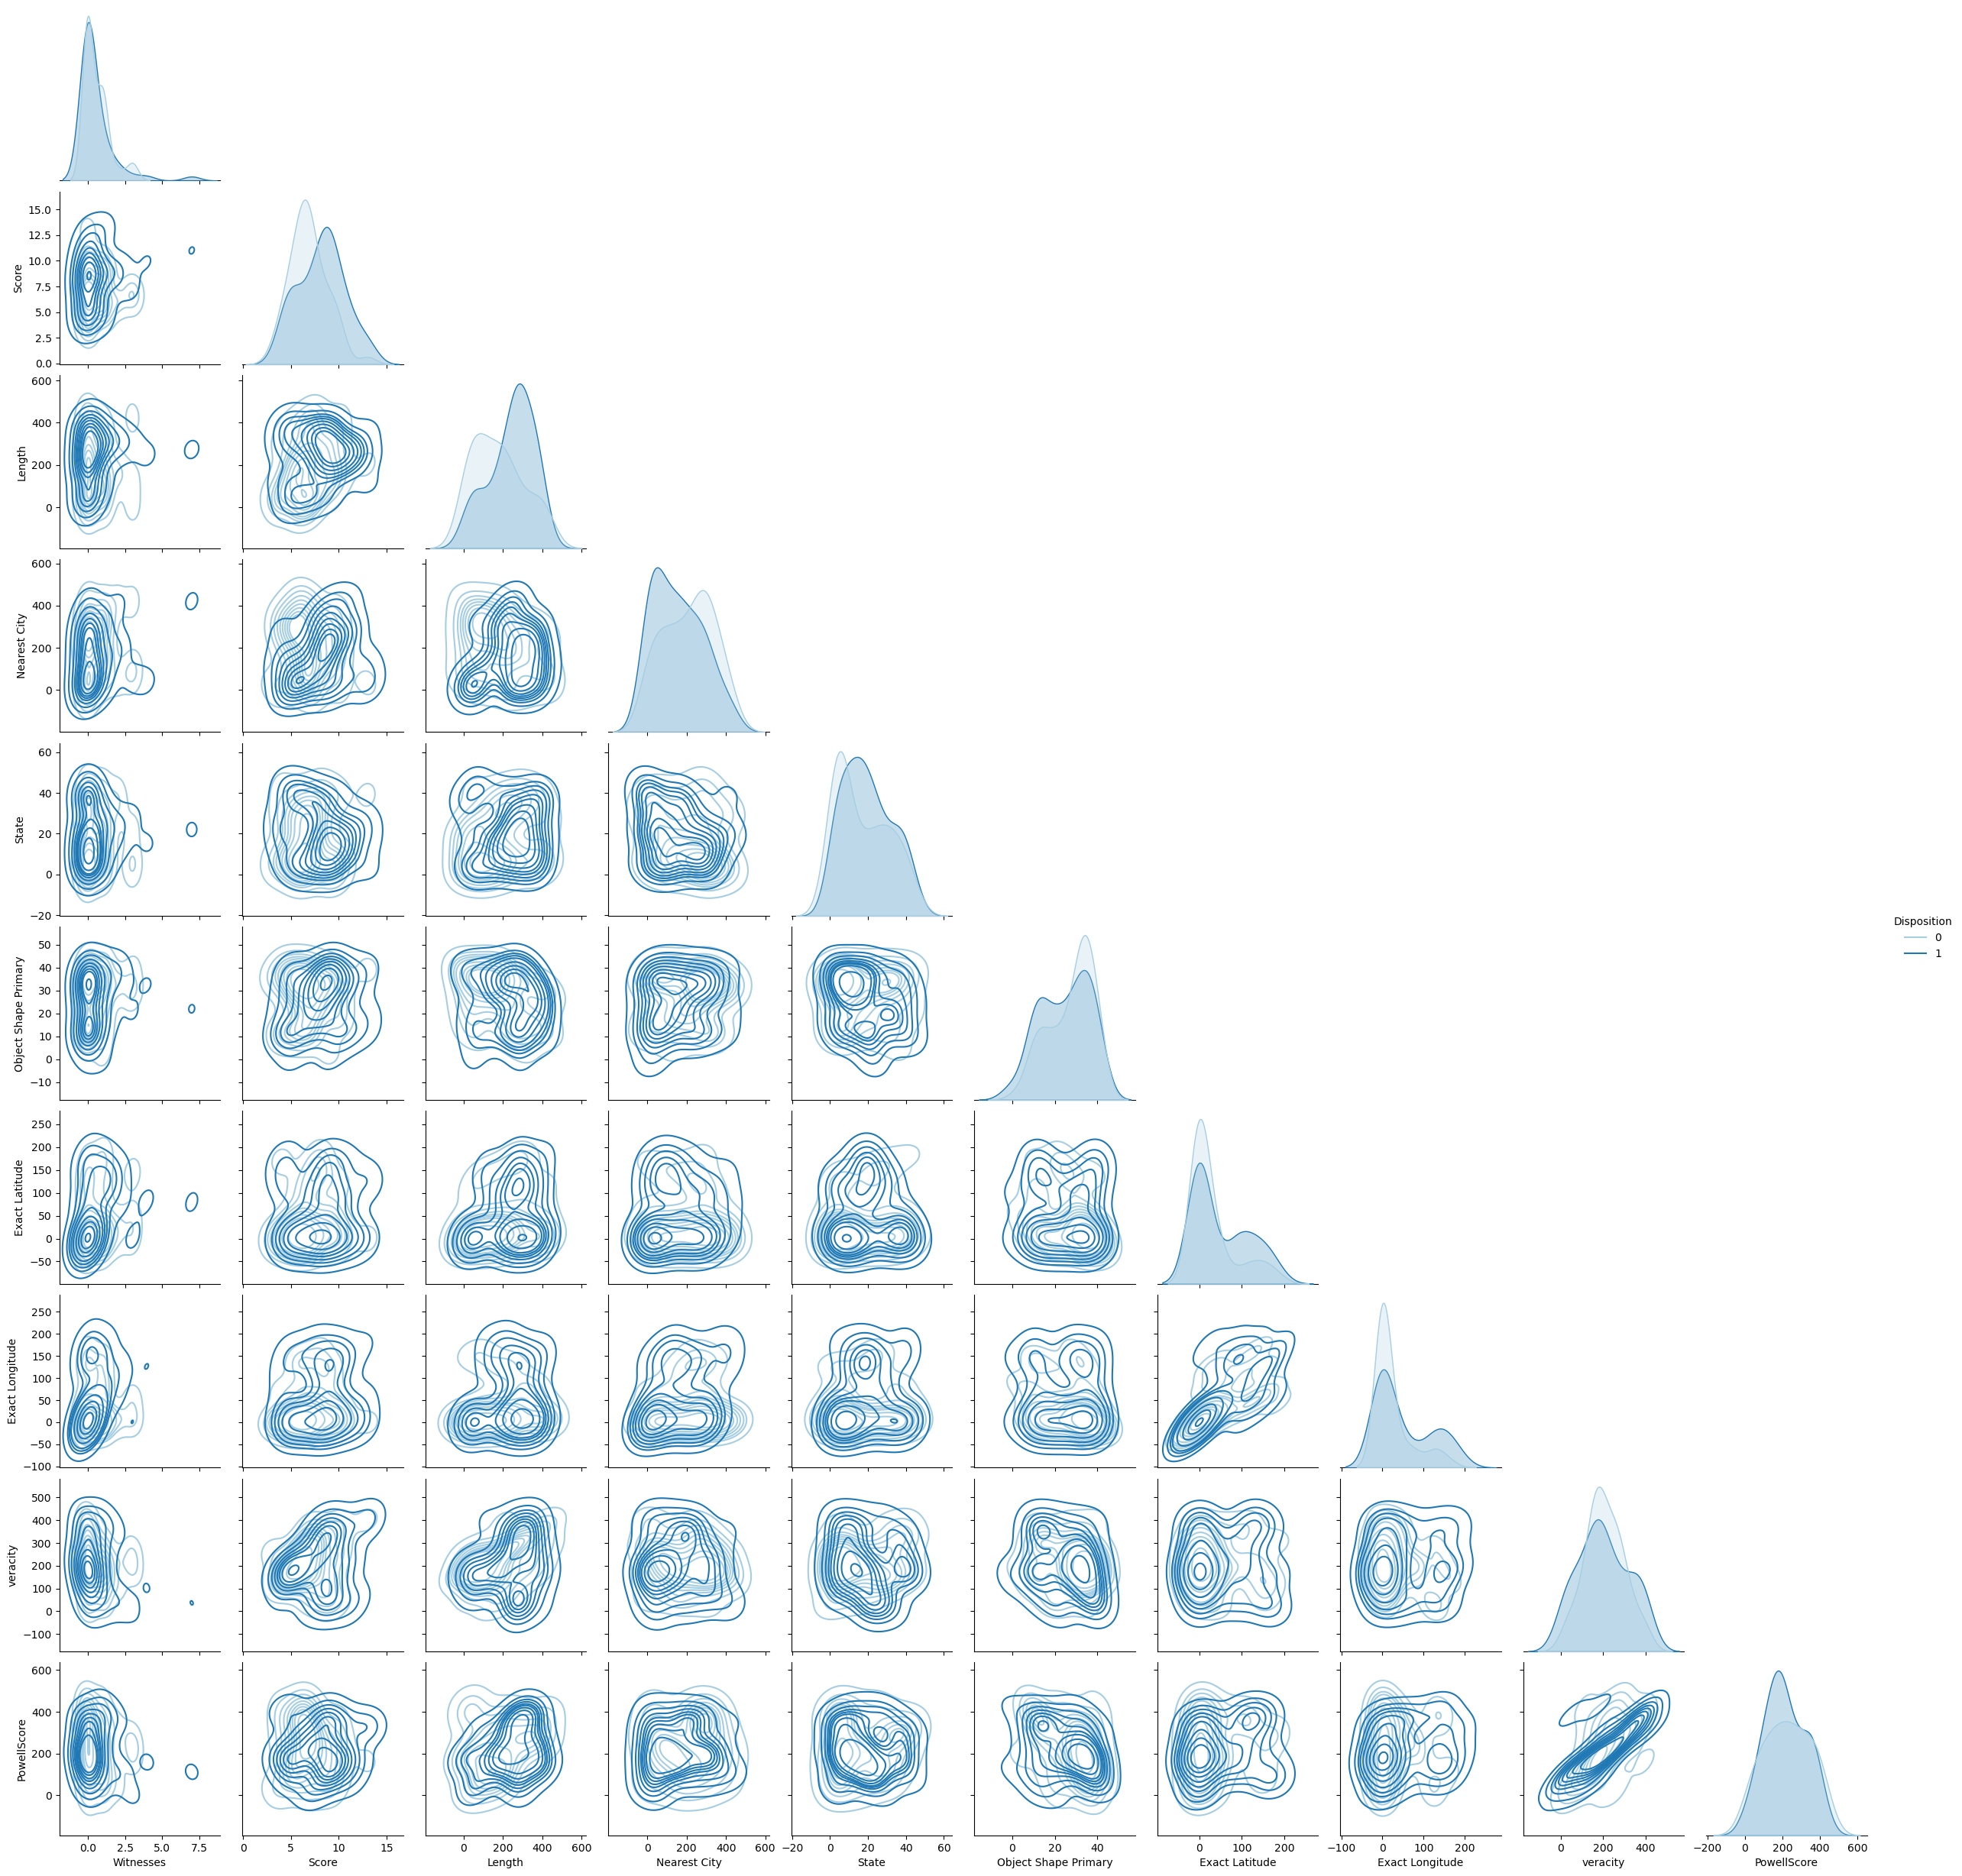

In [26]:
# 'comments' & 'country' - out
sns.pairplot(c[['Witnesses','Score','Length','Nearest City','State','Object Shape Primary','Exact Latitude','Exact Longitude','Disposition','veracity','PowellScore']]\
             .sample(100).copy(),
             hue=f'{target}',
             kind="kde",
             corner=True,
             palette="Paired"
            )

In [27]:
# print encoded item
use_case = pd.DataFrame(c.loc[idx]).T.drop(columns=[target]) 

#c

# print encoded item w/out target info
data = c.drop(columns=[target]) 

print("\nThis is what our encoded 'use-case' looks like - number form, just the way the machine likes it.\n")

use_case.style.background_gradient(cmap ='twilight').set_properties(**{'font-size': '10px'})


This is what our encoded 'use-case' looks like - number form, just the way the machine likes it.



In [28]:
# create X,y variables for ML
# save trainer
print("\nResetting train data...\nCreating X-matrix & y-vector (target) for classification.")
trainer = c.loc[c.index!=idx].copy()
X, y =  trainer.drop(columns=[target]), trainer[target].ravel()
X_train, X_test, y_train, y_test = X_y_sets(trainer, target)[0]


Resetting train data...
Creating X-matrix & y-vector (target) for classification.


In [29]:
X_train['target'] = pd.Series(y_train)
X_train.dropna().head().reset_index(drop=True).reset_index(drop=True).style.background_gradient(cmap ='twilight').set_properties(**{'font-size': '10px'})

In [30]:
# for the sake of adding the 'target' column above for sake of layman's explanation
X_train, X_test, y_train, y_test = X_y_sets(trainer, target)[0]

In [31]:
# encoded variable re-mapping
# specific to our current target choice
d = encoding_remap(a, c, target)
print("\nDecoding our encoded dataframe to correlate with the initial randomly chosen subject.\n")


Decoding our encoded dataframe to correlate with the initial randomly chosen subject.



In [35]:
print("\n-Live prediction-\nThinking...\n")

# MLP
clf = MLPClassifier(alpha=0.666, max_iter=666).fit(X_train, y_train)

print()
print("Test score (confidence): ",clf.score(X_test, y_test)*100,"%")
print()
prediction = clf.predict(use_case)[0]
print(f"Prediction {target} index:",prediction)

# print decoded prediction
print("\nPrediction Decoded")
e = d[d.index == prediction]
e


-Live prediction-
Thinking...


Test score (confidence):  52.121212121212125 %

Prediction Disposition index: 0

Prediction Decoded


Disposition
index            
0           "IFO"

In [36]:
solved = str(e['Disposition'][e.index[0]])
if solution == solved:
    print(f"\nYUP!\n\nThe machine's prediction against target variable '{target}' was correct!\n")
else:
    print("\nNOPE!\nThe machine's prediction was incorrect :(")
    
print()


YUP!

The machine's prediction against target variable 'Disposition' was correct!




In [34]:
# en fin